# Mohammed Adib Oumer, Kaustubh Milind Kulkarni
## CSCI 5654: Linear Integer Programming Final Project
### Simulation of Compressive Sensing on Single Pixel Cameras

In [28]:
# Relevant Imports
import numpy as np
import cvxpy as cp
import time
import pygame
import pygame.camera as pc
import matplotlib.pyplot as plt
import matplotlib.image as img 

from scipy.fftpack import dct
from scipy.linalg import hadamard
from scipy.optimize import linprog
from PIL import Image
from spgl1 import * # spg optimizers
from optimizers import * # basis_pursuit, basis_pursuit_denoising, lasso


### Helper functions

In [ ]:
# Webcam capture
def captureImage(rootN):
    pc.init()  # initialize camera
    camlist = pc.list_cameras() # list of available cameras
    if camlist: # camera detected
        cam = pc.Camera(camlist[0]) #initialize cam with default camera
        width,height = cam.get_size()
        cam.set_controls(True,False,0)
        cam.start() #open camera
        time.sleep(0.5) # might differ depending on camera
        image = cam.get_image() # capture single image
        image = pygame.transform.smoothscale_by(image,(rootN/width,rootN/height))
        image = pygame.transform.grayscale(image)
        pygame.image.save(image, "webcam.png") # save image
        cam.stop()
        im = Image.open("webcam.png").convert('L') #L = grayscale
        # x = pygame.surfarray.array2d(image)
        
        return np.array(im) # pygame.surfarray.array2d(image) # return image as 2D numpy array
    
    else:
        print(f"No camera detected")
        

In [ ]:
# save 2D-arrays as png
def saveImage(arr, i: str, check: bool): # i: identifier, check: True for reconstructed images
    if check:
        im = Image.fromarray(np.round(arr*255)) # png images 0-255
        # if im.mode != 'RGB':
            # im = im.convert('RGB')
        im = im.convert('L')
        im.save("images/"+i+"_webcam_cs.png")
    else:
        im = Image.fromarray(arr) # png images 0-255
        # if im.mode != 'RGB':
            # im = im.convert('RGB')
        im = im.convert('L')
        im.save("images/"+i+"_webcam.png")


## SPC Emulation

In [ ]:
# Simulate image capture similar to a single pixel camera
# unlike our slides, s and x are flipped. x are images, s are coefficients
def spc_emulation(rootN, percentage, basis, sense, Optimizer, constant=None):
    # Sampling an image with a single pixel camera. Given by Kuusela with the
    # relationship s = Psi^T * x, where x is the true image, psi is a basis
    # (such as DCT), s are the samples acquired by the photosensor and * is the
    # matrix multiply.
    # rootN - dimension of x (width or height). Used square images
    # percentage - (M/N =percentage) percentage/number of measurements desired (upper bounded by N, lower bounded by
    # K). K = desired sparsity, N = number of pixels in image
    # basis - compressive basis Psi (here used DCT or Hadamard or identity)
    # sense - sensing matrix Phi (here used random gaussian or bernoulli)
    # y = Phi*x = Phi*Psi*s = Theta*s where s is the K-sparse coefficient vector
    start = time.time()
    N = rootN**2
    M = round(percentage*N)
    x = captureImage(rootN) # x - 2D image (generally considered square images)
    x_flat = x.reshape((N,1)) # vectorize

    # Normalize
    x_flat = x_flat - min(x_flat)
    x_flat = x_flat / max(x_flat)

    # set Psi - compressive basis - orthonormal basis vector
    if (basis == "dct"):
        Psi = np.array(dct(np.eye(N),type=2)) #type 2 dct by default
    elif (basis == "hadamard"):
        Psi = np.array(hadamard(N)/rootN) # N must be power of 2
    else:
        Psi = np.eye(N) # identity

    # set Phi - sensing matrix
    if (sense == "bernoulli"):
        Phi = np.random.binomial(1,0.5,size=(M,N))
    else:
        Phi = np.random.randn(M,N) # gaussian

    # Get measurements y and matrix Theta
    y = Phi@x_flat
    Theta = Phi@Psi

    # Reconstruction using basis pursuit/BPDN/LASSO
    # Call appropriate optimizer
    assert(y.all() != None)
    if (constant == None): 
        s,_,_,info =  Optimizer(Theta, y.flatten(), verbosity=True)
    else: # if tau or sigma is relevant
        s,_,_,info =  Optimizer(Theta, y.flatten(), constant, verbosity=True)
    res = info['xnorm1'][-1] # optimal objective value
    
    # reconstruction
    xhat_flat = Psi@s
    xhat = np.reshape(xhat_flat, (rootN,rootN)) # convert to 2D array
    if str(Optimizer) == "spg_bp": # just a small thing i found out
        xhat = xhat.transpose()
    
    total_time = time.time()-start # from capturing to reconstruction
    print(f"Total time taken: {int(np.floor(total_time/60))} min, {total_time%60} sec.")
    return (x, xhat, x_flat, xhat_flat, res, s)


### Relevant variables

In [ ]:
basis = ["dct", "hadamard", "eye"] # basis matrix choices
sense = ["bernoulli", "gaussian"] # sensing matrix choices
i, j = 0, 1 # i = basis choice, j = sense choice
dim, percentage =  64, 0.5 # image dimensions, % of measurements
sigma, tau = 1e-2, 2  # constants, sigma = BPDN, tau = LASSO. tau hard to decide


### SPC with different optimizers

In [ ]:
# Optimizers: spg_bp
x, xhat, x_flat, xhat_flat, _,s1 = spc_emulation(dim, percentage, basis[i], sense[j], spg_bp)
saveImage(x, "1", False) # x is a 0-255 array. save as png
saveImage(xhat, "1", True) # xhat is a 0-1 array
# MSE, PSNR definitions: https://www.mathworks.com/help/vision/ref/psnr.html
mse1 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr1 = 10*np.log10(1/mse1) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse1}\nPSNR: {psnr1}")


In [ ]:
# Optimizers: custom LP BP
x, xhat, x_flat, xhat_flat, tau,s2 = spc_emulation(dim, percentage, basis[i], sense[j], basis_pursuit)
saveImage(x, "2", False)
saveImage(xhat, "2", True)
mse2 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr2 = 10*np.log10(1/mse2) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse2}\nPSNR: {psnr2}")


In [ ]:
# Optimizers: spg_bpdn
x, xhat, x_flat, xhat_flat,_, s3 = spc_emulation(dim, percentage, basis[i], sense[j], spg_bpdn, constant=sigma)
saveImage(x, "3", False)
saveImage(xhat, "3", True)
mse3 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr3 = 10*np.log10(1/mse3) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse3}\nPSNR: {psnr3}")


In [ ]:
# Optimizers: custom LP BPDN
x, xhat, x_flat, xhat_flat,_,s4 = spc_emulation(dim, percentage, basis[i], sense[j], basis_pursuit_denoising, constant=sigma)
saveImage(x, "4", False)
saveImage(xhat, "4", True)
mse4 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr4 = 10*np.log10(1/mse4) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse4}\nPSNR: {psnr4}")


In [ ]:
# Optimizers: spg_lasso. Tau from BP result above
x, xhat, x_flat, xhat_flat,_,s5 = spc_emulation(dim, percentage, basis[i], sense[j], spg_lasso, constant=tau)
saveImage(x, "5", False)
saveImage(xhat, "5", True)
mse5 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr5 = 10*np.log10(1/mse5) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse5}\nPSNR: {psnr5}")


In [ ]:
# Optimizers: custom LP lasso
x, xhat, x_flat, xhat_flat,_,s6 = spc_emulation(dim, percentage, basis[i], sense[j], lasso, constant=tau)
saveImage(x, "6", False)
saveImage(xhat, "6", True)
mse6 = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr6 = 10*np.log10(1/mse6) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse6}\nPSNR: {psnr6}")


In [ ]:
# Coefficient vector Plot
x_axis = len(s1)
labels = ["SPG_BP", "SPG_BPDN", "SPG_LASSO", "LP_BP", "LP_BPDN", "LP_LASSO"]
for k, s in enumerate([s1,s3,s5,s2,s4,s6]):
    plt.semilogy(range(1,x_axis+1),-np.sort(-abs(s)), label = labels[k])
plt.legend()
plt.title("Coefficient Plot")
plt.xlabel("Order of coefficients (largest to smallest)")
plt.ylabel("|Coefficients|")
plt.savefig('images/coefficient_plots.png', bbox_inches='tight')
plt.show()

In [ ]:
# plot all reconstructed images
fig, axs = plt.subplots(3, 3, figsize=(6.4*1.5, 4.8*1.5), sharey=True, )
axs[0,0].axis('off')
axs[0,2].axis('off')
im = img.imread('images/1_webcam.png') # reading png image file
axs[0,1].imshow(im, cmap='gray') # show image 
axs[0,1].get_xaxis().set_visible(False)
axs[0,1].set_title("Original")

im = img.imread('images/1_webcam_cs.png') # reading png image file 
axs[1,0].imshow(im, cmap='gray') # show image 
axs[1,0].get_xaxis().set_visible(False)
axs[1,0].set_title("SPG_BP")

im = img.imread('images/3_webcam_cs.png') # reading png image file 
axs[1,1].imshow(im, cmap='gray') # show image 
axs[1,1].get_xaxis().set_visible(False)
axs[1,1].set_title("SPG_BPDN")

im = img.imread('images/5_webcam_cs.png') # reading png image file 
axs[1,2].imshow(im, cmap='gray') # show image
axs[1,2].get_xaxis().set_visible(False)
axs[1,2].set_title("SPG_LASSO")

im = img.imread('images/2_webcam_cs.png') # reading png image file 
axs[2,0].imshow(im, cmap='gray') # show image
axs[2,0].get_xaxis().set_visible(False)
axs[2,0].set_title("LP_BP")

im = img.imread('images/4_webcam_cs.png') # reading png image file 
axs[2,1].imshow(im, cmap='gray') # show image 
axs[2,1].get_xaxis().set_visible(False)
axs[2,1].set_title("LP_BPDN")

im = img.imread('images/6_webcam_cs.png') # reading png image file 
axs[2,2].imshow(im, cmap='gray') # show image
axs[2,2].set_title("LP_LASSO")
axs[2,2].get_xaxis().set_visible(False)

fig.savefig('images/compare_all.png', bbox_inches='tight')


### 100x100 images

In [ ]:
# Optimizers: SPG BP. Dimension increased to 100
dim = 100
x, xhat, x_flat, xhat_flat,_, s_spgbp = spc_emulation(dim, percentage, basis[i], sense[j], spg_bp)
saveImage(x, "spgbp", False)
saveImage(xhat, "spgbp", True)
mse_sbp = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr_sbp = 10*np.log10(1/mse_sbp) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse_sbp}\nPSNR: {psnr_sbp}")


In [ ]:
# Optimizers: LP BP
dim = 100
x, xhat, x_flat, xhat_flat,_, s_bp = spc_emulation(dim, percentage, basis[i], sense[j], basis_pursuit, constant=None)
saveImage(x, "bp", False)
saveImage(xhat, "bp", True)
mse_bp = np.linalg.norm(x_flat-xhat_flat)/len(x_flat)
psnr_bp = 10*np.log10(1/mse_bp) # x_flat, xhat_flat from 0 to 1
print(f"MSE: {mse_bp}\nPSNR: {psnr_bp}")


In [ ]:
# Coefficient plot
plt.semilogy(-np.sort(-s_bp)) 
plt.show()
print(sum(s_bp>=1e-8)) # "non-zero" coefficients

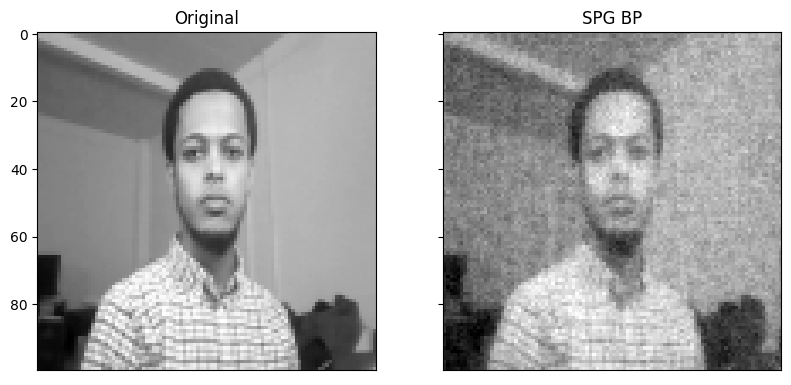

In [26]:
# 100x100 image plots. SPG BP
fig, axs = plt.subplots(1, 2, figsize=(6.4*1.5, 4.8*1.5), sharey=True, )
im = img.imread('images/spgbp_webcam.png') # reading png image file 
axs[0].imshow(im, cmap='gray') # show image 
axs[0].get_xaxis().set_visible(False)
axs[0].set_title("Original")

im = img.imread('images/spgbp_webcam_cs.png') # reading png image file 
axs[1].imshow(im, cmap='gray') # show image 
axs[1].get_xaxis().set_visible(False)
axs[1].set_title("SPG BP")

fig.savefig('images/im100x100_spgbp.png', bbox_inches='tight')

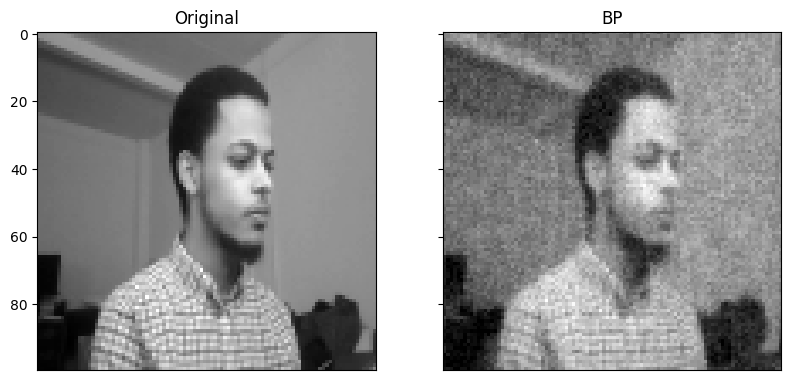

In [27]:
# 100x100 image plots. BP
fig, axs = plt.subplots(1, 2, figsize=(6.4*1.5, 4.8*1.5), sharey=True, )
im = img.imread('images/bp_webcam.png') # reading png image file 
axs[0].imshow(im, cmap='gray') # show image 
axs[0].get_xaxis().set_visible(False)
axs[0].set_title("Original")

im = img.imread('images/bp_webcam_cs.png') # reading png image file 
axs[1].imshow(im, cmap='gray') # show image 
axs[1].get_xaxis().set_visible(False)
axs[1].set_title("BP")

fig.savefig('images/im100x100_bp.png', bbox_inches='tight')